In [2]:
import sys

import logging
import json
import numpy as np
import pandas as pd

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

# from opt_funcs_nsls import make_dummy_eval
sys.path.insert(0, "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-12_APSU_DA_MA")
import opt_funcs

logger = logging.getLogger(__name__)

SETUP

In [3]:
# Load precomputed data

MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

# optimizer variables in units of K2L
#variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
variables = {'SVD0':[-0.4,0.4]} # this means SM1B will change by ~10%

for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    # variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]
    variables[k] = [-np.abs(initial_values_ref[k])*0.075,np.abs(initial_values_ref[k])*0.075]

# objectives_active = {'LT':'MAXIMIZE'}
# objectives_active = {'EFF':'MAXIMIZE'}
objectives_active = {'LT': 'MAXIMIZE', 'EFF':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))



       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.4 -0.297494 -0.087827 -0.237314 -0.199074 -0.535169 -0.441913
1   0.4  0.297494  0.087827  0.237314  0.199074  0.535169  0.441913


In [20]:
reference_point = {'LT':2.0, # hours
                   'EFF': 40.0 # % injected
                   }

In [21]:
opt.generator.reference_point = reference_point

In [4]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]
    return group_relative_strengths

def knobs_to_family(inputs_dict):
    d = compute_family_k2l_from_knob_k2l(dfknobs, inputs_dict, True)
    return opt_funcs.master_eval_function(d)

In [5]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, True)
inputs_dict

SL1: -2.654 + -0.199 -> -2.853
SL2: 7.136 + -0.535 -> 6.600
SL3: -5.892 + -0.442 -> -6.334
SH1: 3.967 + -0.297 -> 3.669
SH3: -1.171 + -0.088 -> -1.259
SH4: -3.164 + -0.237 -> -3.401
SM1A: -4.736 + 0.265 -> -4.471
SM1B: -5.189 + -0.298 -> -5.487
SM2B: 7.161 + 0.035 -> 7.195


{'SL1': -2.8533953007500004,
 'SL2': 6.6004154682500005,
 'SL3': -6.334085031150001,
 'SH1': 3.6690887385,
 'SH3': -1.25884830815,
 'SH4': -3.40149365265,
 'SM1A': -4.47066061076,
 'SM1B': -5.48713351964,
 'SM2B': 7.19541887475}

In [32]:
if True:
    opt_funcs.master_eval_function(inputs_dict)

RMS(dx, dy) [m] = (7.087e-04, 7.281e-04)
RMS(dx, dy) [m] = (0.000e+00, 0.000e+00)
Orbit correction converged


Lifetime calc failed
Traceback (most recent call last):
  File "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-12_APSU_DA_MA/opt_funcs.py", line 468, in master_eval_function
    tau_suppl = res["moni_data"]
                ~~~^^^^^^^^^^^^^
KeyError: 'moni_data'



Traceback (most recent call last):
  File "/nsls2/users/yhidaka/git_repos/nsls2scripts3/shifts/2023-11-12_APSU_DA_MA/opt_funcs.py", line 468, in master_eval_function
    tau_suppl = res["moni_data"]
                ~~~^^^^^^^^^^^^^
KeyError: 'moni_data'

Lifetime = nan (took 0.3 [s])
Inj. Eff. = 0.01 (took 14.4 [s])
Eval. func. finished.


In [7]:
# eval_f = make_dummy_eval(gvocs)
eval_f = knobs_to_family
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 128 #512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
#gen.max_travel_distances = [0.1] * len(gvocs.variables_active)
gen.reference_point = reference_point

In [8]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

Sample at initial values (i.e. standard lattice)

In [9]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

SL1: -2.654 + 0.000 -> -2.654
SL2: 7.136 + 0.000 -> 7.136
SL3: -5.892 + 0.000 -> -5.892
SH1: 3.967 + 0.000 -> 3.967
SH3: -1.171 + 0.000 -> -1.171
SH4: -3.164 + 0.000 -> -3.164
SM1A: -4.736 + 0.000 -> -4.736
SM1B: -5.189 + 0.000 -> -5.189
SM2B: 7.161 + 0.000 -> 7.161
RMS(dx, dy) [m] = (3.380e-04, 1.723e-05)
SOFB not enabled yet. Enabling now!
RMS(dx, dy) [m] = (5.325e-05, 5.477e-06)
RMS(dx, dy) [m] = (2.861e-05, 1.946e-06)
RMS(dx, dy) [m] = (2.860e-05, 2.298e-06)
RMS(dx, dy) [m] = (1.171e-05, 9.769e-07)
RMS(dx, dy) [m] = (7.947e-06, 2.807e-06)
Orbit correction converged
** # of outliers found = 6 (out of 180)
Lifetime = 10.1 (took 7.6 [s])
SOFB enabled. Disabling now!
Inj. Eff. = 76.83 (took 19.0 [s])
Eval. func. finished.


In [10]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'LT': 10.10785523335368, 'EFF': 76.8299523207...",None,,47.786666,13.944466,True,10.107855,76.829952,0.223021,0.254088,2.221707e-09,1.647612e-11


Sample close to initial point

In [12]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

SL1: -2.654 + 0.007 -> -2.648
SL2: 7.136 + -0.016 -> 7.119
SL3: -5.892 + -0.002 -> -5.894
SH1: 3.967 + 0.011 -> 3.977
SH3: -1.171 + 0.004 -> -1.167
SH4: -3.164 + 0.009 -> -3.155
SM1A: -4.736 + -0.007 -> -4.743
SM1B: -5.189 + 0.008 -> -5.181
SM2B: 7.161 + -0.001 -> 7.160
RMS(dx, dy) [m] = (3.602e-06, 1.182e-06)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 10.1 (took 10.8 [s])
Inj. Eff. = 77.29 (took 19.0 [s])
Eval. func. finished.


In [13]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,"{'LT': 10.10785523335368, 'EFF': 76.8299523207...",None,,47.786666,13.944466,True,10.107855,76.829952,0.223021,0.254088,2.221707e-09,1.647612e-11
2,0.010484,0.010774,0.00366,0.008892,0.006622,-0.016318,-0.002188,"{'LT': 10.146789878609466, 'EFF': 77.288076182...",None,,35.918124,16.904044,True,10.146790,77.288076,0.222533,0.253691,2.230863e-09,1.649257e-11


In [14]:
opt.step()

SL1: -2.654 + 0.096 -> -2.558
SL2: 7.136 + -0.236 -> 6.899
SL3: -5.892 + -0.032 -> -5.924
SH1: 3.967 + 0.156 -> 4.122
SH3: -1.171 + 0.053 -> -1.118
SH4: -3.164 + 0.129 -> -3.036
SM1A: -4.736 + -0.101 -> -4.837
SM1B: -5.189 + 0.113 -> -5.076
SM2B: 7.161 + -0.013 -> 7.148
RMS(dx, dy) [m] = (1.432e-04, 6.047e-06)
SOFB not enabled yet. Enabling now!
RMS(dx, dy) [m] = (1.080e-05, 2.054e-06)
RMS(dx, dy) [m] = (1.002e-05, 3.059e-06)
RMS(dx, dy) [m] = (3.306e-06, 9.779e-07)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 10.6 (took 6.9 [s])
SOFB enabled. Disabling now!
Inj. Eff. = 82.55 (took 19.1 [s])
Eval. func. finished.


Run optimizer

In [28]:
import warnings
#warnings.filterwarnings("ignore", message="Unable to find non-zero acquisition function values")

for i in range(10):
    print(f'\n** Step #{i+1} **\n')
    opt.step()


** Step #1 **

SL1: -2.654 + 0.199 -> -2.455
SL2: 7.136 + -0.285 -> 6.851
SL3: -5.892 + -0.088 -> -5.980
SH1: 3.967 + 0.144 -> 4.111
SH3: -1.171 + 0.065 -> -1.106
SH4: -3.164 + 0.154 -> -3.010
SM1A: -4.736 + -0.059 -> -4.795
SM1B: -5.189 + 0.066 -> -5.123
SM2B: 7.161 + -0.008 -> 7.153
RMS(dx, dy) [m] = (8.790e-05, 3.269e-06)
SOFB not enabled yet. Enabling now!
RMS(dx, dy) [m] = (1.081e-05, 2.733e-06)
RMS(dx, dy) [m] = (5.764e-06, 1.247e-06)
Orbit correction converged
** # of outliers found = 4 (out of 180)
Lifetime = 11.0 (took 11.0 [s])
SOFB enabled. Disabling now!
Inj. Eff. = 83.54 (took 17.4 [s])
Eval. func. finished.

** Step #2 **

SL1: -2.654 + 0.138 -> -2.516
SL2: 7.136 + -0.333 -> 6.802
SL3: -5.892 + 0.012 -> -5.881
SH1: 3.967 + 0.149 -> 4.116
SH3: -1.171 + 0.039 -> -1.132
SH4: -3.164 + 0.237 -> -2.927
SM1A: -4.736 + 0.008 -> -4.728
SM1B: -5.189 + -0.009 -> -5.199
SM2B: 7.161 + 0.001 -> 7.162
RMS(dx, dy) [m] = (3.827e-05, 2.670e-06)
SOFB not enabled yet. Enabling now!
RMS(dx, 

In [17]:
print(opt.state_to_json())

{
  "optimizer": {
    "tag": "d9db48429c",
    "store_history": true,
    "dump_every_step": true,
    "history_directory": null,
    "execution_mode": "sync"
  },
  "generator": {
    "name": "aps_mobo",
    "n_monte_carlo_samples": 128,
    "turbo_controller": null,
    "use_cuda": false,
    "gp_constructor": {
      "name": "mobo_model",
      "use_low_noise_prior": false,
      "covar_modules": {},
      "mean_modules": {},
      "trainable_mean_keys": [],
      "use_high_noise_prior": false
    },
    "numerical_optimizer": {
      "name": "APSLBFGS",
      "n_raw_samples": 128,
      "n_restarts": 10,
      "max_iter": 2000,
      "sequential": true
    },
    "max_travel_distances": null,
    "fixed_features": null,
    "computation_time": null,
    "n_candidates": 1,
    "reference_point": {
      "LT": 2.0,
      "EFF": 0.4
    },
    "prune_inferior_points_kwargs": null
  },
  "evaluator": {
    "name": "func",
    "on_error": "ignore",
    "max_workers": 1,
    "script": "

In [29]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn
39,0.366769,0.210632,0.087827,0.217984,0.114684,-0.415878,-0.042562,"{'LT': 10.856434781149558, 'EFF': 84.994913327...",None,,47.065446,25.242072,True,10.856435,84.994913,0.220916,0.252928,2.218926e-09,1.642831e-11
40,0.400000,0.172632,0.058525,0.086650,0.199074,-0.289153,-0.121939,"{'LT': 10.702004472354155, 'EFF': 84.300284041...",None,,42.383472,25.130394,True,10.702004,84.300284,0.220214,0.255400,2.210039e-09,1.636668e-11
41,0.086926,0.134847,0.087827,0.120723,0.199074,-0.297723,0.008677,"{'LT': 11.1317793363635, 'EFF': 82.94220217164...",None,,38.918419,21.470083,True,11.131779,82.942202,0.223387,0.252013,2.194086e-09,1.670362e-11
42,0.331159,0.227061,0.083548,0.187572,0.092991,-0.344177,-0.079278,"{'LT': 10.924220034016463, 'EFF': 84.865088568...",None,,37.467929,24.640631,True,10.924220,84.865089,0.220610,0.252715,2.207191e-09,1.647597e-11
43,0.101425,0.182078,0.087827,0.237314,0.121793,-0.413435,0.004297,"{'LT': 11.320854092789615, 'EFF': 82.578841679...",None,,41.915656,25.728388,True,11.320854,82.578842,0.222350,0.250609,2.185637e-09,1.714035e-11


Text(0, 0.5, 'Hypervolume')

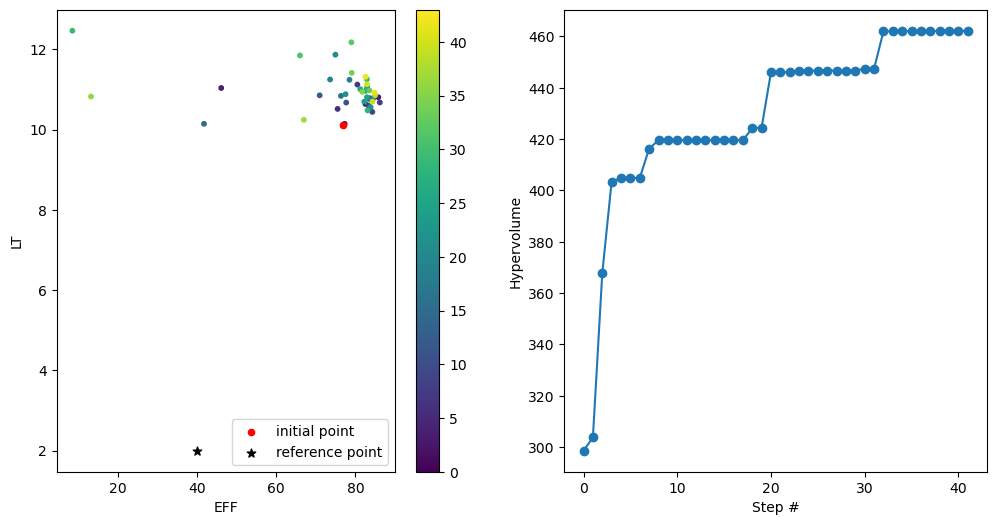

In [30]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

In [31]:
# This will save optimizer state
from datetime import datetime
opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_exp_mobo_{MODE}_v1_dump.json')

'{\n  "optimizer": {\n    "tag": "d9db48429c",\n    "store_history": true,\n    "dump_every_step": true,\n    "history_directory": null,\n    "execution_mode": "sync"\n  },\n  "generator": {\n    "name": "aps_mobo",\n    "n_monte_carlo_samples": 128,\n    "turbo_controller": null,\n    "use_cuda": false,\n    "gp_constructor": {\n      "name": "mobo_model",\n      "use_low_noise_prior": false,\n      "covar_modules": {},\n      "mean_modules": {},\n      "trainable_mean_keys": [],\n      "use_high_noise_prior": false\n    },\n    "numerical_optimizer": {\n      "name": "APSLBFGS",\n      "n_raw_samples": 128,\n      "n_restarts": 10,\n      "max_iter": 2000,\n      "sequential": true\n    },\n    "max_travel_distances": null,\n    "fixed_features": null,\n    "computation_time": null,\n    "n_candidates": 1,\n    "reference_point": {\n      "LT": 2.0,\n      "EFF": 40.0\n    },\n    "prune_inferior_points_kwargs": null\n  },\n  "evaluator": {\n    "name": "func",\n    "on_error": "igno